# Time Series Forecasting using ETS and TBATS models
- This tutorial covers developing multiple **Error,Trend,Seasonal**:`ETS` and **Trigonometric seasonality, Box-Cox transformation, ARMA errors, Trend and Seasonal**:`TBATS` models to predict forecasts for a time series data.
-  Monthly anti-diabetic drug sales : [a10](https://rdrr.io/cran/fpp/man/a10.html) dataset from the `fpp` package in R language has been taken for model development.

In [1]:
# importing libraries necessary for data transformation, data pre-processing, model development etc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels as sm
import statsmodels.tsa
import statsmodels.tsa.seasonal

from matplotlib.legend import Legend
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error
from tbats import TBATS, BATS

import warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# defining some user-defined functions that will be called later

def ts_plot(ts, ts_name_x, ts_name_y):
    '''Function to display the plot for a given Time Series. 
       The plot also shows the mean value of the y-value of the Time Series '''
    plt.figure(figsize=(12,6))
    plt.plot(ts)
    plt.title(ts_name_x, fontsize=15)
    plt.ylabel(ts_name_y, fontsize=12)
    
    for year in range(ts.index[0].year, ts.index[-1].year+2):
        plt.axvline(pd.to_datetime(str(year)), color='k', linestyle='--', alpha=0.2)
        
    plt.axhline(ts.mean().Sales, color='r', alpha=0.2, linestyle='--')
    plt.text(ts.index[0], (ts.mean().Sales)+0.01, 'Mean : {}'.format(round((ts.mean().Sales),2)))
    plt.show()

### 1. Data import and exploratory analysis

In [3]:
# model development data
df = pd.read_csv('/content/a10.csv')

In [4]:
df.head()

,Date,Sales
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [5]:
df1 = df.copy()

In [6]:
# converting index into sales dates : this will later help in plotting sales with right time
sales = df1
sales.index = pd.to_datetime(df1.Date)
sales = sales.drop(['Date'], axis=1)

In [7]:
print(sales.head())
print(sales.tail())
print(sales.shape)

               Sales
Date                
1991-07-01  3.526591
1991-08-01  3.180891
1991-09-01  3.252221
1991-10-01  3.611003
1991-11-01  3.565869
                Sales
Date                 
2008-02-01  21.654285
2008-03-01  18.264945
2008-04-01  23.107677
2008-05-01  22.912510
2008-06-01  19.431740
(204, 1)


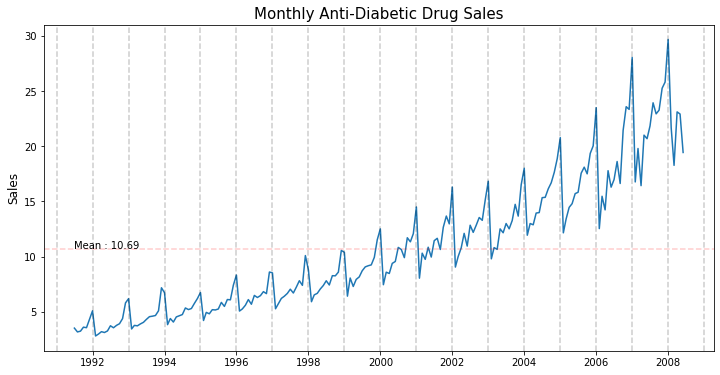

In [8]:
# We can see that this data-set captures monthly drug sales for 17 years (204 months). <br> 
# Next step is to plot and see this Time-Series.  

ts_plot(sales, 'Monthly Anti-Diabetic Drug Sales', 'Sales') 

From the Time-Series plot, we can observe that : <br>
1. There is a clear upward trend with the passage of time.<br>
2. There seems to be a cyclic-trend (*Yearly*) in the Time Series.<br>
3. Volatility in each cycle increases with the passage of time.

### 2. Model Development

In [9]:
# Split model development data into test and train dataset, such that :
# First 16 years of data(192 data points for 192 months) for training data
# Last(17th year) year's data(12 data points for last 12 months) for testing data

train_df = sales.iloc[:192]
test_df = sales.iloc[-12:]

#### 2.1 ETS family models

**Time Series Decomposition**

Before developing ETS models, we'll apply different **decomposition** techniques on the Time Series. This well later help in selecting the right type of *Exponential Smoothening* technique to apply in the ETS models.

**2.1.1.a. Standard Additive Decomposition**

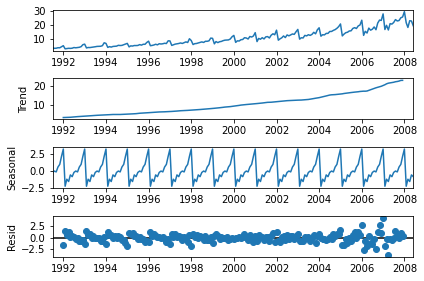

In [10]:
decomposition = statsmodels.tsa.seasonal.seasonal_decompose(sales, model='additive')
fig = decomposition.plot()
plt.show()

**2.1.1.b. Standard Multiplicative Decomposition**

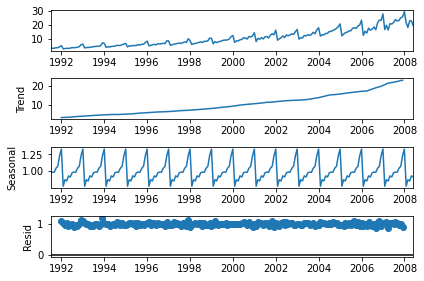

In [11]:
decomposition = statsmodels.tsa.seasonal.seasonal_decompose(sales, model='multiplicative')
fig = decomposition.plot()
plt.show()

**2.1.1.c Loess STL decomposition**

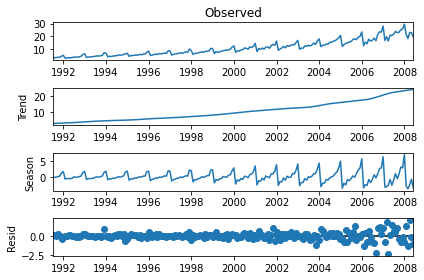

In [12]:
decomposition = STL(sales)
decomposition =  decomposition.fit()
fig = decomposition.plot()
plt.show()

**Insights from the decomposition plots :**

- Seasonal component fluctuates between ±1.25 in Additive decomposition and between ±2.5 in Multiplicative decomposition. However, in Loess decomposition, fluctuation in the seasonal component gradually increases.
- Residual component is mostly distributed around 0 and disperses with time in Additive decomposition, but is pretty much distriubuted around 1 in Multiplicative decomposition. Residual component Loess decomposition captures the Residual patterns from both Additive and Multiplicative decomposition.
- It seems that both additive and multiplicative component are present in the time series.

**2.1.2 ETS Models:**<br>
We'll fit different permutation of Additive and Multiplicative techniques in **Holt-Winters Exponenential Smoothening** models

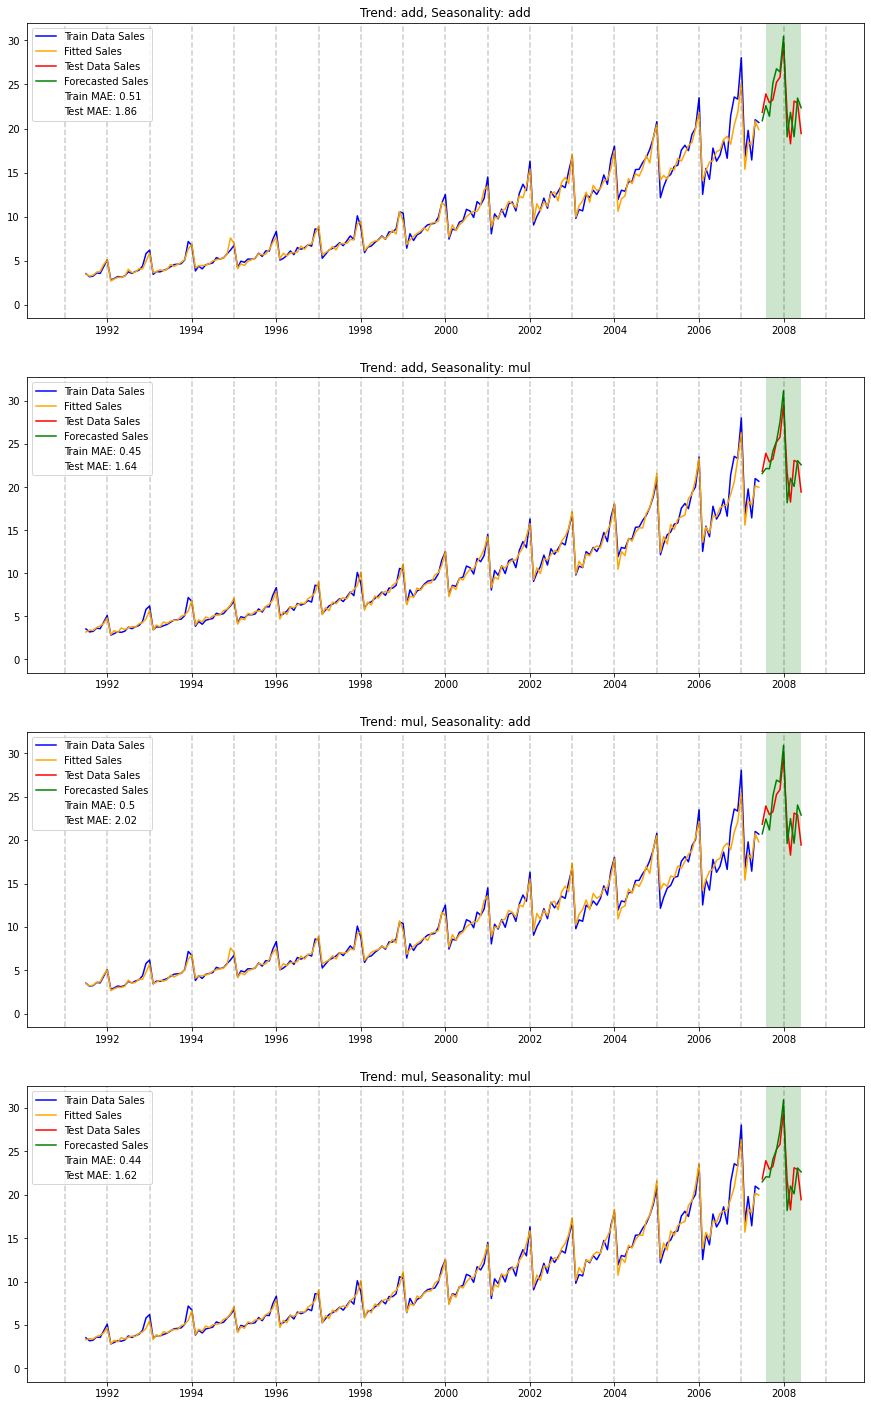

In [13]:
# define forecast period of 1 year(12 months)
forecast_periods = 12

# defining all values for trends and seasonality
trends = ['add', 'mul']
seasonality = ['add', 'mul']

# dictionary to save all permutations of trends and seasonality models
es_models, es_fits = {}, {}
plot_pos = 0

fig, axs = plt.subplots(4, 1, figsize=(15, 25))

for trend in trends:
    for seasonal in seasonality:
        # define model with trend and seasonality parameters 
        es_model = ExponentialSmoothing(train_df, trend=trend,
                                        seasonal=seasonal, seasonal_periods=12)
        # fit model
        es_fit = es_model.fit()

        # forecast predictions
        forecast = es_fit.forecast(forecast_periods)
        
        # calculate forecast errors on train and test data : Mean Absolute Error has been used here
        train_error = round((mean_absolute_error(train_df, es_fit.fittedvalues)),2)
        test_error = round((mean_absolute_error(test_df, forecast)),2)
        
        # save model name in the model dictionary
        key = 'trend:_{}, seasonal:_{}'.format(trend, seasonal)
        title = 'Trend: {}, Seasonality: {}'.format(trend, seasonal)
        es_models[key], es_fits[key] = es_model, es_fit
        
        # plot model forecasts
        axs[plot_pos].plot(train_df, label='Train Data Sales', color = 'blue')
        axs[plot_pos].plot(es_fit.fittedvalues, label='Fitted Sales', color = 'orange')
        axs[plot_pos].plot(test_df, label='Test Data Sales', color = 'red')
        axs[plot_pos].plot(forecast, label = 'Forecasted Sales', color = 'green')
        axs[plot_pos].plot(train_df.index[0], 0, label = 'Train MAE: {}'.format(train_error), color = 'white')
        axs[plot_pos].plot(train_df.index[0], 0, label = 'Test MAE: {}'.format(test_error), color = 'white')
        for year in range(sales.index[0].year, sales.index[203].year+2):
            axs[plot_pos].axvline(pd.to_datetime(str(year)), color='k', linestyle='--', alpha=0.2)
        axs[plot_pos].axvspan(sales.index[193], sales.index[203], facecolor='green', alpha=0.2)
        axs[plot_pos].set_title(title)
        axs[plot_pos].legend()
        
        plot_pos = plot_pos + 1
        
plt.show()

In [14]:
# parameter and performance details for all ETS models

for key, es_model in es_fits.items():
    print('Exponential Smooting', key, '\n')
    print(es_model.summary())

Exponential Smooting trend:_add, seasonal:_add 

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Sales   No. Observations:                  192
Model:             ExponentialSmoothing   SSE                            111.550
Optimized:                         True   AIC                            -72.260
Trend:                         Additive   BIC                            -20.140
Seasonal:                      Additive   AICC                           -68.307
Seasonal Periods:                    12   Date:                 Thu, 21 Apr 2022
Box-Cox:                          False   Time:                         05:55:42
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1987481                alp

From model performance plots and model summary details, it seems that **Holt Winters Exponential Smoothening** model with *Multiplicative Trend* and *Multiplicative Seasonality* perform the best on Train and Test data(Lowest value for AIC, Train-MAE, Test-MAE).

### **2.1.2 TBATS Models**

In [15]:
# define TBATS model, with seasonality value = 12 months
tbats_model = TBATS(use_box_cox = True, seasonal_periods=[12])

# fit TBATs model on training data
tbats_model = tbats_model.fit(train_df)

# parameter and performance details for all ETS models 
print(tbats_model.summary())

Use Box-Cox: True
Use trend: True
Use damped trend: False
Seasonal periods: [12.]
Seasonal harmonics [5]
ARMA errors (p, q): (4, 3)
Box-Cox Lambda 0.115949
Smoothing (Alpha): 0.265085
Trend (Beta): 0.013193
Damping Parameter (Phi): 1.000000
Seasonal Parameters (Gamma): [ 3.86517427e-05 -1.11843868e-05]
AR coefficients [-1.11843868e-05  1.57945786e-01 -4.58539674e-01 -2.62268597e-02]
MA coefficients [-0.27506136  0.17878268  0.33758808]
Seed vector [ 1.23822078e+00  2.74947535e-04 -7.91247043e-02  8.25895943e-02
 -5.96477591e-02  6.65641513e-02 -5.52720046e-02  1.49784340e-01
 -9.86629813e-02  7.04653787e-02 -4.36563766e-02  5.32239105e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00]

AIC 812.334001


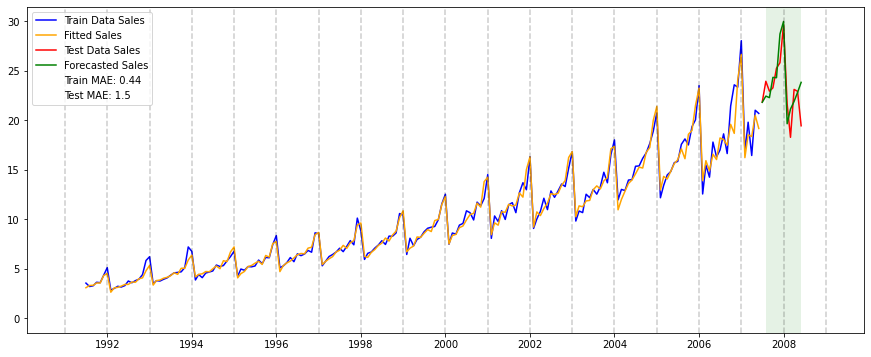

In [16]:
# define forecast period = 12months
forecast_periods = 12

# forecasts predictions
forecast, confidence_intv = tbats_model.forecast(steps=forecast_periods, confidence_level=0.95)

# calculate forecast errors on train and test data : Mean Absolute Error has been used here
train_error = round((mean_absolute_error(train_df, tbats_model.y_hat)),2)
test_error = round((mean_absolute_error(test_df, forecast)),2)

fitted_series = pd.Series(tbats_model.y_hat, index=train_df.index)
forecast_series = pd.Series(forecast, index=test_df.index)

# plot model forecasts
plt.figure(figsize=(15,6))
plt.plot(train_df, label='Train Data Sales', color = 'blue')
plt.plot(fitted_series, label='Fitted Sales', color = 'orange')
plt.plot(test_df, label='Test Data Sales', color = 'red')
plt.plot(forecast_series, label = 'Forecasted Sales', color = 'green')
plt.plot(train_df.index[0], 0, label = 'Train MAE: {}'.format(train_error), color = 'white')
plt.plot(train_df.index[0], 0, label = 'Test MAE: {}'.format(test_error), color = 'white')
for year in range(sales.index[0].year, sales.index[203].year+2):
    plt.axvline(pd.to_datetime(str(year)), color='k', linestyle='--', alpha=0.2)
plt.axvspan(sales.index[193], sales.index[203], facecolor='g', alpha=0.1)
plt.legend()
plt.show()        

TBATS model has outperformed all the Exponential Smoothening models as it has lower MAE value for both Train and Test data.